 # Lab 1 Task 1

 ## 1. Implement the following layers as Python functions (both forward and backward propagation)# * Inner-product layer# * Activation layer(Sigmoid or Rectified)# * Softmax layer

In [1]:
# !pip install matplotlib numpy tqdm google

# # %% [code] cell 4
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
# %cd /content/drive/MyDrive/AI_lab/Lab1\ Material


In [3]:
import os
from typing import Callable, Iterable, Optional
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
import csv
from itertools import product
import time


In [4]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
        self.grad = None


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs) 

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'
    
    def forward(self, x):
        raise NotImplementedError("Subclasses should implement this!")
    
    def backward(self, dy):
        raise NotImplementedError("Subclasses should implement this!")

In [5]:
class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        # y = x @ W + b
        # x: (N, in_features), W: (in_features, out_features), b: (1, out_features)
        self.x = x
        return x @ self.W.data + self.b.data

    def backward(self, dy):
        # dy: (N, out_features)
        # dW = x^T @ dy, db = sum(dy), dx = dy @ W^T
        # Make sure self.x is not None
        if self.x is None:
            raise ValueError("self.x is None. Did you forget to call forward before backward?")
        dW = self.x.T @ dy                                  # (in_features, out_features)
        db = np.sum(dy, axis=0, keepdims=True)              # (1, out_features)
        dx = dy @ self.W.data.T                             # (N, in_features)

        # 寫回參數的梯度（通常外面會有 zero_grad() 再累加或覆蓋）
        self.W.grad = dW
        self.b.grad = db
        return dx

    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        # y = max(0, x)
        self.x = x
        return np.maximum(0, x)

    def backward(self, dy):
        # 確保 self.x 不是 None
        if self.x is None:
            raise ValueError("self.x is None. Did you forget to call forward before backward?")
        # dy ⊙ 1_{x > 0}
        mask = (self.x > 0).astype(dy.dtype)
        return dy * mask

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # y = 1 / (1 + exp(-x))
        # 儲存 y 以便 backward 使用 y*(1-y)
        y = 1.0 / (1.0 + np.exp(-x))
        self.y = y
        return y

    def backward(self, dy):
        # 確保 self.y 不是 None
        if self.y is None:
            raise ValueError("self.y is None. Did you forget to call forward before backward?")
        # dy ⊙ y(1 - y)
        return dy * (self.y * (1.0 - self.y))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 數值穩定 softmax
        # x: (N, C)
        x_shift = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(x_shift)
        y = exps / np.sum(exps, axis=1, keepdims=True)
        self.y = y
        return y

    def backward(self, dy):
        # 通常與 Cross-Entropy 合併成簡化梯度 (y - one_hot)
        # 這裡維持講義設定：在 CE Loss 內完成簡化，因此此處直接回傳 dy
        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class MLP(Module):
    def __init__(self) -> None:
        # 保持原模板的 __init__ 介面（不帶參數）
        self.fc1 = Linear(28*28, 256)
        self.act1 = ReLU()
        self.fc2 = Linear(256, 10)

    def forward(self, x):
        # x: (N, 784) with values in [0,1]
        z1 = self.fc1(x)
        a1 = self.act1(z1)
        z2 = self.fc2(a1)  # logits
        return z2

    def backward(self, dy):
        # dy: gradient w.r.t logits
        dz2 = self.fc2.backward(dy)
        dz1 = self.act1.backward(dz2)
        dx  = self.fc1.backward(dz1)
        return dx

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

 ## 2. Implement training and testing process# * included cross-validation

In [6]:
class MNIST:
    # root請根據你的檔案位置更改
    def __init__(self, root='../data', train=True, transform: Optional[Callable] = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = list(indices)  # Ensure indices is sized

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)


In [7]:
# Separate train_imgs, train_labels into training and validation
# root請根據你的檔案位置更改
def load_mnist_data(root=".", batch_size=1, split_ratio=0.1, transform=None) -> tuple[DataLoader, DataLoader, DataLoader]:
    # split_ratio: fraction of training data to use for validation
    def _split_dataset(dataset, split_ratio):
        # split dataset into training and validation sets
        # hint: return Subset(dataset, train_indices), Subset(dataset, valid_indices)
        n = len(dataset)
        indices = np.random.permutation(n)
        n_valid = int(n * split_ratio)
        valid_indices = indices[:n_valid]
        train_indices = indices[n_valid:]
        return Subset(dataset, train_indices), Subset(dataset, valid_indices)


    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr


In [8]:

class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        if self.y_true is None or self.y_pred is None:
            raise ValueError("Must call forward before backward.")
        batch_size = self.y_true.shape[0]
        grad = (self.y_pred - self.y_true) / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)


In [9]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0.0
    for x, y in tqdm(trainldr):
        # 1) forward
        logits = model(x)
        # 2) loss (one-hot labels)
        num_classes = 10
        # y_onehot = np.eye(num_classes, dtype=np.float32)[y]
        if y.ndim == 2 and y.shape[1] == num_classes:
            # 已是 one-hot
            y_onehot = y.astype(np.float32)
            y_idx = np.argmax(y, axis=1)
        else:
            # 整數類別
            y_idx = y.astype(np.int64).reshape(-1)
            y_onehot = np.eye(num_classes, dtype=np.float32)[y_idx]
        loss = criterion.forward(logits, y_onehot)

        # 3) accuracy
        pred = np.argmax(logits, axis=1)
        # The y here is one-hot, convert it back to integer class indices for comparison
        y_idx = np.argmax(y_onehot, axis=1)
        correct += int((pred == y_idx).sum())
        bs = x.shape[0]
        total += bs
        total_loss += loss * bs
        # 4) backward
        dlogits = criterion.backward()
        model.backward(dlogits)
        # 5) update
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

    snaps = []
    for p in model.parameters():
        snaps.append(np.array(p.data, copy=True))
    return snaps

def evaluate(model: Module, dataldr: Iterable) -> tuple[float, float]:
    criterion = CrossEntropyLoss()
    total = 0
    correct = 0
    total_loss = 0.0
    for x, y in tqdm(dataldr):
        logits = model(x)
        num_classes = 10
        # Ensure y is one-hot encoded for loss calculation and correct for accuracy
        if y.ndim == 2 and y.shape[1] == num_classes:
            # Already one-hot
            y_onehot = y.astype(np.float32)
            y_idx = np.argmax(y, axis=1)
        else:
            # Integer classes
            y_idx = y.astype(np.int64).reshape(-1)
            y_onehot = np.eye(num_classes, dtype=np.float32)[y_idx]

        loss = criterion.forward(logits, y_onehot)
        pred = np.argmax(logits, axis=1)
        correct += int((pred == y_idx).sum()) # Compare prediction with integer class index
        bs = x.shape[0]
        total += bs
        total_loss += loss * bs

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    # 這邊提供SGD作為optimizer，同學也可以根據自己人需求更換其他optimizer
    optimizer = SGD(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

def multicore_train(model: MLP, trainldr: Iterable, validldr: Iterable,
          epochs=10, lr=1e-3, *,
          mode="single",
          processes=max(1, (os.cpu_count() or 2) - 2),
          global_batch_size=256,
          start_method="fork"):
    """
    mode="single"：單機逐batch更新（使用原本的 train_one_epoch）
    mode="step_reduce"：同一epoch內多核心同步平均梯度（Step-reduce）
    """
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr)

    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []

    for epoch in range(epochs):
        if mode == "step_reduce":
            # 多核心版：每個 step 聚合梯度後更新一次
            loss, acc = train_one_epoch_step_reduce(
                model, trainldr, optimizer,
                processes=processes,
                global_batch_size=global_batch_size,
                num_classes=10,
                start_method=start_method
            )
        else:
            # 單機版：用你原本已定義的 train_one_epoch
            loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)

        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        v_loss, v_acc = evaluate(model, validldr)
        valid_loss.append(v_loss)
        valid_acc.append(v_acc)
        print(f'epoch {epoch:d}: valid_loss = {v_loss}, valid_acc = {v_acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

def load_weights(model, snaps):
    """把快照載回到同架構模型。"""
    for p, s in zip(model.parameters(), snaps):
        p.data = s.copy()

def prepare_targets(y, num_classes=10):
    """支援 int label 或 one-hot，回傳 (y_onehot, y_idx)。"""
    if y.ndim == 2 and y.shape[1] == num_classes:
        y_onehot = y.astype(np.float32)
        y_idx = np.argmax(y, axis=1)
    else:
        y_idx = y.astype(np.int64).reshape(-1)
        y_onehot = np.eye(num_classes, dtype=np.float32)[y_idx]
    return y_onehot, y_idx

def make_steps(trainldr, global_batch_size=256):
    """把 train loader 攤平成 list，依全域 batch 大小切成多個 step。"""
    batches = list(trainldr)  # [(x,y), ...]
    steps, cur, cur_n = [], [], 0
    for (x, y) in batches:
        cur.append((x, y))
        cur_n += x.shape[0]
        if cur_n >= global_batch_size:
            steps.append(cur)
            cur, cur_n = [], 0
    if cur:
        steps.append(cur)
    return steps

def snapshot_weights(model):
    """把模型參數拍成 numpy 快照，便於序列化傳到子行程。"""
    snaps = []
    for p in model.parameters():
        snaps.append(np.array(p.data, copy=True))
    return snaps

def split_for_workers(step_batches, workers):
    """把單一步的批次平均分配給多個 workers。"""
    workers = max(1, workers)
    parts = [[] for _ in range(workers)]
    for i, item in enumerate(step_batches):
        parts[i % workers].append(item)
    return [p for p in parts if p]  # 去除空分片（避免資料太少時為空）

def worker_step_reduce(weights_snap, sub_batches, num_classes=10):
    """
    子行程：拿到當前權重快照 + 一份子批次集合，計算梯度總和與統計並回傳。
    注意：這裡建立自己的 loss 與模型，避免跨行程共享物件。
    """
    net = MLP()
    load_weights(net, weights_snap)

    # 本 worker 的梯度累加器（形狀與權重相同）
    grad_acc = [np.zeros_like(w) for w in weights_snap]
    loss_sum, corr, tot = 0.0, 0, 0

    local_criterion = CrossEntropyLoss()

    for (x, y) in sub_batches:
        logits = net.forward(x)
        y_onehot, y_idx = prepare_targets(y, num_classes)
        loss = local_criterion.forward(logits, y_onehot)

        dlogits = local_criterion.backward()
        _ = net.backward(dlogits)

        # 累加每個參數的梯度
        for gi, p in enumerate(net.parameters()):
            grad_acc[gi] += p.grad

        # 統計
        loss_sum += float(loss)
        corr     += int((np.argmax(logits, axis=1) == y_idx).sum())
        tot      += x.shape[0]

        # 清梯度（避免跨 batch 疊加）
        for p in net.parameters():
            if p.grad is not None:
                p.grad[...] = 0

    return grad_acc, loss_sum, corr, tot

def train_one_epoch_step_reduce(model, trainldr, optimizer,
                                processes=4, global_batch_size=256,
                                num_classes=10, start_method="fork"):
    """
    同一個 epoch 內的同步資料並行（Step-reduce）：
      對每個 step：
        1) 主行程拍權重快照並廣播
        2) 多個 worker 各算子批梯度
        3) 主行程把梯度按樣本數平均後，更新一次參數
    回傳：(epoch_loss, epoch_acc)
    """
    # 把 trainldr 攤平成多個 step, step : global_batch data
    steps = make_steps(trainldr, global_batch_size=global_batch_size)
    if len(steps) == 0:
        return 0.0, 0.0
    ctx = mp.get_context(start_method)

    epoch_loss, epoch_corr, epoch_tot = 0.0, 0, 0
    with ProcessPoolExecutor(max_workers=processes, mp_context=ctx) as ex:
        for step_batches in steps:
            # 把 batch data 分給多個 worker
            parts = split_for_workers(step_batches, processes)
            # 將 當前模型權重拍成快照
            w_snap = snapshot_weights(model)

            futs = [ex.submit(worker_step_reduce, w_snap, part, num_classes) for part in parts]

            # 聚合本 step 的梯度與統計
            agg_grads = None
            step_loss, step_corr, step_tot = 0.0, 0, 0
            for f in futs:
                g_part, l_part, c_part, t_part = f.result()
                if agg_grads is None:
                    agg_grads = [np.zeros_like(g) for g in g_part]
                for gi in range(len(agg_grads)):
                    agg_grads[gi] += g_part[gi]
                step_loss += l_part
                step_corr += c_part
                step_tot  += t_part

            # 以樣本數平均梯度（對齊 batch-mean）
            for p, g in zip(model.parameters(), agg_grads if agg_grads is not None else []):
                p.grad = g / float(step_tot)

            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += step_loss
            epoch_corr += step_corr
            epoch_tot  += step_tot

    return epoch_loss / len(steps), epoch_corr / epoch_tot

In [10]:
def transform(x):
    """map pixels information from range(0, 255) to range(0.01, 1)"""
    x = np.asarray(x, dtype=np.float32) / 255.0
    return np.asarray(x) * 0.99 + 0.01


In [11]:
# "../data"請根據你的檔案位置更改
trainldr, validldr, testldr = load_mnist_data(
    ".", batch_size=1, transform=transform
)
print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break


train set: 54000 images
validation set: 6000 images
test set: 10000 images
x shape: (1, 784)
y shape: (1, 10)


 ## 3. Plot loss & accuracy curves(both Training and Validation)

In [19]:
# ========== 小工具：存 CSV ==========
def save_summary_csv(path, rows):
    """
    rows: list of dicts with keys:
      run_id, epochs, lr, mode, final_train_loss, final_train_acc,
      final_valid_loss, final_valid_acc, test_loss, test_acc
    """
    fieldnames = [
        "run_id","epochs","lr","mode",
        "final_train_loss","final_train_acc",
        "final_valid_loss","final_valid_acc",
        "test_loss","test_acc"
    ]
    with open(path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in rows:
            writer.writerow(r)

def save_history_csv(path, histories):
    """
    histories: list of dicts; each dict:
      {
        "run_id": int,
        "epochs": int,
        "lr": float,
        "mode": str,
        "history": [
            {"epoch": i, "train_loss":..., "train_acc":..., "valid_loss":..., "valid_acc":...}, ...
        ]
      }
    → 輸出長表，每列對應 (run_id, epoch)
    """
    fieldnames = ["run_id","epochs","lr","mode","epoch",
                  "train_loss","train_acc","valid_loss","valid_acc"]
    with open(path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for h in histories:
            meta = {k: h[k] for k in ("run_id","epochs","lr","mode")}
            for row in h["history"]:
                out = dict(meta); out.update(row)
                writer.writerow(out)

# ========== 畫疊圖 ==========
def plot_overlay(results, save_prefix=""):
    """
    results: list of dicts, 每組格式：
      {
        "run_id": int,
        "config": {"epochs": int, "lr": float, "mode": str},
        "train_loss": [..], "train_acc":[..],
        "valid_loss":[..], "valid_acc":[..],
        "test_loss": float, "test_acc": float
      }
    會畫三張圖：loss_overlay.png、acc_overlay.png、test_acc_overlay.png 並 plt.show()
    """
    for i, r in enumerate(results):
        r["run_id"] = i + 1  # 從 1 開始編號
        
    # --- Loss ---
    plt.figure()
    for i, r in enumerate(results):
        label = f"Run{r['run_id']} | ep={r['config']['epochs']} lr={r['config']['lr']} [{r['config']['mode']}]"
        x = range(1, len(r["train_loss"])+1)
        plt.plot(x, r["train_loss"], label=f"{label} - train")
        plt.plot(x, r["valid_loss"], label=f"{label} - valid")
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.title("Training/Validation Loss (overlay)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}loss_overlay.png", dpi=150)
    plt.show()

    # --- Accuracy ---
    plt.figure()
    for r in results:
        label = f"Run{r['run_id']} | ep={r['config']['epochs']} lr={r['config']['lr']} [{r['config']['mode']}]"
        x = range(1, len(r["train_acc"])+1)
        plt.plot(x, r["train_acc"], label=f"{label} - train")
        plt.plot(x, r["valid_acc"], label=f"{label} - valid")
    plt.xlabel("epoch"); plt.ylabel("accuracy")
    plt.title("Training/Validation Accuracy (overlay)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}acc_overlay.png", dpi=150)
    plt.show()

    items = []
    for r in results:
        ep = r["config"]["epochs"]; lr = r["config"]["lr"]; acc = r["test_acc"]
        items.append((f"ep{ep}-lr{lr:g}", acc))
    items.sort(key=lambda x: x[1], reverse=True)
    labels = [k for k,_ in items]; values = [v for _,v in items]

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(values)), values)
    plt.xticks(range(len(values)), labels, rotation=30, ha="right")
    plt.ylabel("test accuracy"); plt.title("Summary of configs (test_acc)")
    plt.tight_layout()
    plt.savefig(os.path.join(save_prefix, "summary_test_acc.png"), dpi=150)
    plt.show()



## 4. run parallel training (by multi-core)

In [20]:
# ========== 一鍵跑多組（逐組執行，避免巢狀多進程） ==========
def run_config_with_multicores(cfg,
                               data_root=".",
                               batch_size=128,
                               global_batch_size=256,
                               per_config_cores=5,
                               start_method="fork"):
    # 限制 BLAS 執行緒，避免跟多進程互搶
    os.environ.setdefault("OMP_NUM_THREADS", "1")
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS", "1")

    # 1) Data
    trainldr, validldr, testldr = load_mnist_data(
        data_root, batch_size=batch_size, transform=transform
    )

    # 2) Model
    net = MLP()

    # 3) Train （確保 train 支援 mode="step_reduce" 與 processes）
    train_loss, train_acc, valid_loss, valid_acc = multicore_train(
        net, trainldr, validldr,
        epochs=cfg["epochs"], lr=cfg["lr"],
        mode="step_reduce",
        processes=per_config_cores,
        global_batch_size=global_batch_size,
        start_method=start_method
    )

    # 4) Test
    test_loss, test_acc = evaluate(net, testldr)

    return {
        "config": {"epochs": cfg["epochs"], "lr": cfg["lr"], "mode": "step_reduce",
                   "cores": per_config_cores},
        "train_loss": list(map(float, train_loss)),
        "train_acc":  list(map(float, train_acc)),
        "valid_loss": list(map(float, valid_loss)),
        "valid_acc":  list(map(float, valid_acc)),
        "test_loss": float(test_loss),
        "test_acc":  float(test_acc),
    }

def run_many_configs_in_parallel(configs,
                                 data_root=".",
                                 batch_size=128,
                                 global_batch_size=256,
                                 per_config_cores=5,
                                 start_method="fork",
                                 save_dir="results_parallel"):
    """
    同時併行多組 config：
      - 每個 config 由一個外層進程執行 run_config_with_multicores（內部再用 per_config_cores）
      - 外層進程數 = floor(CPU / per_config_cores)，自動限流避免塞爆機器
      - 全部完成後輸出 Overlay 圖與 Summary 長條圖（test_acc）

    回傳：results（每組 config 的完整結果）
    """
    os.makedirs(save_dir, exist_ok=True)

    cpu_total = (os.cpu_count() or 1)
    max_parallel = max(1, cpu_total // max(1, per_config_cores))
    print(f"[Scheduler] CPU={cpu_total} | per-config cores={per_config_cores} "
          f"→ max_parallel_configs={max_parallel}")

    ctx = mp.get_context(start_method)
    results = []

    with ProcessPoolExecutor(max_workers=max_parallel, mp_context=ctx) as ex:
        futures = []
        for cfg in configs:
            fut = ex.submit(
                run_config_with_multicores,
                cfg, data_root, batch_size, global_batch_size, per_config_cores, start_method
            )
            futures.append(fut)

        for fut in as_completed(futures):
            res = fut.result()
            cfg = res["config"]
            print(f"Finished: ep={cfg['epochs']}, lr={cfg['lr']}, "
                  f"cores={cfg['cores']}, test_acc={res['test_acc']:.4f}")
            results.append(res)
    # ---- Overlay: Loss, Accuracy ----
    plot_overlay(results, save_prefix=os.path.join(save_dir, ""))
        # ---- Save CSV ----
    save_summary_csv(os.path.join(save_dir, "results_summary.csv"), [
        {
            "run_id": i+1,
            "epochs": r["config"]["epochs"],
            "lr": r["config"]["lr"],
            "mode": r["config"]["mode"],
            "final_train_loss": r["train_loss"][-1],
            "final_train_acc": r["train_acc"][-1],
            "final_valid_loss": r["valid_loss"][-1],
            "final_valid_acc": r["valid_acc"][-1],
            "test_loss": r["test_loss"],
            "test_acc": r["test_acc"]
        } for i, r in enumerate(results)
    ])
    save_history_csv(os.path.join(save_dir, "results_history.csv"), [
        {
            "run_id": i+1,
            "epochs": r["config"]["epochs"],
            "lr": r["config"]["lr"],
            "mode": r["config"]["mode"],
            "history": [
                {
                    "epoch": ei+1,
                    "train_loss": float(r["train_loss"][ei]),
                    "train_acc": float(r["train_acc"][ei]),
                    "valid_loss": float(r["valid_loss"][ei]),
                    "valid_acc": float(r["valid_acc"][ei])
                } for ei in range(len(r["train_loss"]))
            ]
        } for i, r in enumerate(results)
    ])
    return results

## 5. 多組超參數的訓練

[Scheduler] CPU=32 | per-config cores=5 → max_parallel_configs=6
epoch 0: train_loss = 20.410026600502515, train_acc = 0.15851851851851853


 91%|█████████▏| 43/47 [00:27<00:02,  1.87it/s]

epoch 0: train_loss = 49.72163888182524, train_acc = 0.13307407407407407


  6%|▋         | 3/47 [00:01<00:27,  1.62it/s]

epoch 0: valid_loss = 3.6498228913115365, valid_acc = 0.20583333333333334



  9%|▊         | 4/47 [00:02<00:26,  1.60it/s]

epoch 0: train_loss = 31.934841879688474, train_acc = 0.14162962962962963


 30%|██▉       | 14/47 [00:06<00:14,  2.32it/s]

epoch 0: train_loss = 31.934841879688474, train_acc = 0.14162962962962963


 38%|███▊      | 18/47 [00:09<00:15,  1.89it/s]

epoch 0: train_loss = 49.72163888182524, train_acc = 0.13307407407407407


 13%|█▎        | 6/47 [00:03<00:20,  2.04it/s]]

epoch 0: train_loss = 20.410026600502515, train_acc = 0.15851851851851853


 87%|████████▋ | 41/47 [00:19<00:02,  2.30it/s]

epoch 0: valid_loss = 22.987408190334367, valid_acc = 0.13183333333333333



 79%|███████▊  | 37/47 [00:17<00:04,  2.27it/s]

epoch 0: valid_loss = 6.49236216149471, valid_acc = 0.15383333333333332



100%|██████████| 47/47 [00:21<00:00,  2.15it/s]


epoch 0: valid_loss = 6.49236216149471, valid_acc = 0.15383333333333332



100%|██████████| 47/47 [00:20<00:00,  2.31it/s]


epoch 0: valid_loss = 22.987408190334367, valid_acc = 0.13183333333333333



100%|██████████| 47/47 [00:19<00:00,  2.45it/s]


epoch 0: valid_loss = 3.6498228913115365, valid_acc = 0.20583333333333334

epoch 1: train_loss = 6.4462701561575395, train_acc = 0.2873888888888889


100%|██████████| 47/47 [00:30<00:00,  1.53it/s]


epoch 1: valid_loss = 2.920358637655711, valid_acc = 0.36466666666666664

epoch 1: train_loss = 8.834992162430485, train_acc = 0.17659259259259258


 40%|████      | 19/47 [00:11<00:15,  1.80it/s]

epoch 1: train_loss = 8.834992162430485, train_acc = 0.17659259259259258


 43%|████▎     | 20/47 [00:11<00:14,  1.88it/s]

epoch 1: train_loss = 6.4462701561575395, train_acc = 0.2873888888888889


  2%|▏         | 1/47 [00:00<00:30,  1.49it/s]]

epoch 1: train_loss = 40.893600018669524, train_acc = 0.13644444444444445


  4%|▍         | 2/47 [00:01<00:25,  1.75it/s]

epoch 1: train_loss = 40.893600018669524, train_acc = 0.13644444444444445


 53%|█████▎    | 25/47 [00:11<00:09,  2.41it/s]


epoch 1: valid_loss = 3.6500709685501382, valid_acc = 0.206



100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


epoch 1: valid_loss = 2.920358637655711, valid_acc = 0.36466666666666664


epoch 1: valid_loss = 3.6500709685501382, valid_acc = 0.206




100%|██████████| 47/47 [00:20<00:00,  2.29it/s]


epoch 1: valid_loss = 18.003084764139153, valid_acc = 0.136



100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


epoch 1: valid_loss = 18.003084764139153, valid_acc = 0.136

epoch 2: train_loss = 5.480789732741185, train_acc = 0.4191666666666667


100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


epoch 2: valid_loss = 2.5853534898457204, valid_acc = 0.46216666666666667

epoch 2: train_loss = 6.787830687068944, train_acc = 0.24725925925925926


 68%|██████▊   | 32/47 [00:20<00:11,  1.33it/s]

epoch 2: train_loss = 5.480789732741185, train_acc = 0.4191666666666667


 30%|██▉       | 14/47 [00:08<00:18,  1.77it/s]


epoch 2: valid_loss = 3.1908629669678077, valid_acc = 0.287



 38%|███▊      | 18/47 [00:10<00:16,  1.79it/s]

epoch 2: train_loss = 30.977536189805463, train_acc = 0.14066666666666666


 51%|█████     | 24/47 [00:12<00:10,  2.18it/s]

epoch 2: train_loss = 30.977536189805463, train_acc = 0.14066666666666666


 55%|█████▌    | 26/47 [00:13<00:09,  2.20it/s]

epoch 2: train_loss = 6.787830687068944, train_acc = 0.24725925925925926


100%|██████████| 47/47 [00:23<00:00,  2.04it/s]


epoch 2: valid_loss = 2.5853534898457204, valid_acc = 0.46216666666666667



100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


epoch 2: valid_loss = 13.149725707808017, valid_acc = 0.14116666666666666



100%|██████████| 47/47 [00:22<00:00,  2.13it/s]


epoch 2: valid_loss = 13.149725707808017, valid_acc = 0.14116666666666666



100%|██████████| 47/47 [00:23<00:00,  2.04it/s]


epoch 2: valid_loss = 3.1908629669678077, valid_acc = 0.287

epoch 3: train_loss = 4.962387840246286, train_acc = 0.49905555555555553


100%|██████████| 47/47 [00:28<00:00,  1.67it/s]


epoch 3: valid_loss = 2.3852601495913595, valid_acc = 0.533

epoch 3: train_loss = 6.099571672834226, train_acc = 0.3287962962962963


100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


epoch 3: valid_loss = 2.920524669611559, valid_acc = 0.3641666666666667

epoch 3: train_loss = 4.962387840246286, train_acc = 0.49905555555555553


  4%|▍         | 2/47 [00:01<00:32,  1.39it/s]

epoch 3: train_loss = 22.21085492161947, train_acc = 0.14562962962962964


 26%|██▌       | 12/47 [00:08<00:22,  1.54it/s]

epoch 3: train_loss = 22.21085492161947, train_acc = 0.14562962962962964


 77%|███████▋  | 36/47 [00:20<00:04,  2.25it/s]

epoch 3: train_loss = 6.099571672834226, train_acc = 0.3287962962962963


 23%|██▎       | 11/47 [00:04<00:14,  2.51it/s]


epoch 3: valid_loss = 2.3852601495913595, valid_acc = 0.533



100%|██████████| 47/47 [00:28<00:00,  1.67it/s]


epoch 3: valid_loss = 9.258950466630338, valid_acc = 0.149



100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


epoch 3: valid_loss = 9.258950466630338, valid_acc = 0.149



100%|██████████| 47/47 [00:19<00:00,  2.43it/s]


epoch 3: valid_loss = 2.920524669611559, valid_acc = 0.3641666666666667

epoch 4: train_loss = 4.6392375515714726, train_acc = 0.5597592592592593


100%|██████████| 47/47 [00:29<00:00,  1.61it/s]


epoch 4: valid_loss = 2.255073034994529, valid_acc = 0.5838333333333333

epoch 4: train_loss = 5.6460084416250425, train_acc = 0.3947777777777778


100%|██████████| 47/47 [00:30<00:00,  1.55it/s]


epoch 4: valid_loss = 2.7292209578952336, valid_acc = 0.4191666666666667

epoch 4: train_loss = 15.457123017182642, train_acc = 0.15066666666666667


 64%|██████▍   | 30/47 [00:18<00:11,  1.54it/s]

epoch 4: train_loss = 4.6392375515714726, train_acc = 0.5597592592592593


 72%|███████▏  | 34/47 [00:21<00:08,  1.49it/s]

epoch 4: train_loss = 5.6460084416250425, train_acc = 0.3947777777777778


 21%|██▏       | 10/47 [00:05<00:18,  2.02it/s]

epoch 4: train_loss = 15.457123017182642, train_acc = 0.15066666666666667


100%|██████████| 47/47 [00:27<00:00,  1.68it/s]


epoch 4: valid_loss = 6.492542704695167, valid_acc = 0.15366666666666667



100%|██████████| 47/47 [00:22<00:00,  2.09it/s]


epoch 4: valid_loss = 2.255073034994529, valid_acc = 0.5838333333333333



100%|██████████| 47/47 [00:23<00:00,  2.02it/s]


epoch 4: valid_loss = 2.7292209578952336, valid_acc = 0.4191666666666667



100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


epoch 4: valid_loss = 6.492542704695167, valid_acc = 0.15366666666666667

epoch 5: train_loss = 4.422006869366166, train_acc = 0.6077407407407407


100%|██████████| 47/47 [00:32<00:00,  1.47it/s]


epoch 5: valid_loss = 2.164079335830162, valid_acc = 0.6218333333333333

epoch 5: train_loss = 5.314705004205242, train_acc = 0.44353703703703706


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 5: valid_loss = 2.585495299787749, valid_acc = 0.4618333333333333

epoch 5: train_loss = 4.422006869366166, train_acc = 0.6077407407407407


 21%|██▏       | 10/47 [00:07<00:27,  1.35it/s]

epoch 5: train_loss = 11.418538839784786, train_acc = 0.1570925925925926


 79%|███████▊  | 37/47 [00:23<00:05,  1.93it/s]

epoch 5: train_loss = 11.418538839784786, train_acc = 0.1570925925925926


 89%|████████▉ | 42/47 [00:26<00:02,  2.04it/s]

epoch 5: train_loss = 5.314705004205242, train_acc = 0.44353703703703706


100%|██████████| 47/47 [00:28<00:00,  1.65it/s]


epoch 5: valid_loss = 2.164079335830162, valid_acc = 0.6218333333333333



100%|██████████| 47/47 [00:23<00:00,  1.97it/s]


epoch 5: valid_loss = 5.084556103172512, valid_acc = 0.161



100%|██████████| 47/47 [00:22<00:00,  2.09it/s]


epoch 5: valid_loss = 5.084556103172512, valid_acc = 0.161



100%|██████████| 47/47 [00:22<00:00,  2.05it/s]


epoch 5: valid_loss = 2.585495299787749, valid_acc = 0.4618333333333333

epoch 6: train_loss = 4.264379198947279, train_acc = 0.6400185185185185


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 6: valid_loss = 2.095074992078723, valid_acc = 0.6495

epoch 6: train_loss = 5.061540638524582, train_acc = 0.48305555555555557


100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


epoch 6: valid_loss = 2.4739034127251074, valid_acc = 0.501

epoch 6: train_loss = 4.264379198947279, train_acc = 0.6400185185185185


 53%|█████▎    | 25/47 [00:18<00:16,  1.36it/s]

epoch 6: train_loss = 9.32374326110944, train_acc = 0.16474074074074074


  4%|▍         | 2/47 [00:01<00:31,  1.45it/s]]

epoch 6: train_loss = 9.32374326110944, train_acc = 0.16474074074074074


 15%|█▍        | 7/47 [00:03<00:20,  1.94it/s]]

epoch 6: train_loss = 5.061540638524582, train_acc = 0.48305555555555557

 79%|███████▊  | 37/47 [00:24<00:04,  2.04it/s]

 21%|██▏       | 10/47 [00:04<00:17,  2.11it/s]

epoch 6: valid_loss = 2.095074992078723, valid_acc = 0.6495



 89%|████████▉ | 42/47 [00:20<00:02,  1.90it/s]

epoch 6: valid_loss = 4.363205913873962, valid_acc = 0.17



100%|██████████| 47/47 [00:22<00:00,  2.07it/s]


epoch 6: valid_loss = 4.363205913873962, valid_acc = 0.17



100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


epoch 6: valid_loss = 2.4739034127251074, valid_acc = 0.501

epoch 7: train_loss = 4.139920859621875, train_acc = 0.6600370370370371


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


epoch 7: valid_loss = 2.0381313644707424, valid_acc = 0.6676666666666666

epoch 7: train_loss = 4.862839717166766, train_acc = 0.5163518518518518


100%|██████████| 47/47 [00:28<00:00,  1.62it/s]


epoch 7: valid_loss = 2.385364887601866, valid_acc = 0.5333333333333333

epoch 7: train_loss = 4.139920859621875, train_acc = 0.6600370370370371


 28%|██▊       | 13/47 [00:09<00:25,  1.32it/s]

epoch 7: train_loss = 4.862839717166766, train_acc = 0.5163518518518518


 34%|███▍      | 16/47 [00:09<00:15,  2.02it/s]

epoch 7: train_loss = 8.34407776968287, train_acc = 0.17451851851851852


 74%|███████▍  | 35/47 [00:22<00:06,  1.96it/s]

epoch 7: train_loss = 8.34407776968287, train_acc = 0.17451851851851852

 49%|████▉     | 23/47 [00:12<00:12,  1.92it/s]

100%|██████████| 47/47 [00:27<00:00,  1.72it/s]


epoch 7: valid_loss = 2.0381313644707424, valid_acc = 0.6676666666666666



100%|██████████| 47/47 [00:24<00:00,  1.95it/s]


epoch 7: valid_loss = 2.385364887601866, valid_acc = 0.5333333333333333



100%|██████████| 47/47 [00:24<00:00,  1.95it/s]


epoch 7: valid_loss = 3.99631494874458, valid_acc = 0.17966666666666667



100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


epoch 7: valid_loss = 3.99631494874458, valid_acc = 0.17966666666666667

epoch 8: train_loss = 4.033405870473334, train_acc = 0.6727592592592593


100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


epoch 8: valid_loss = 1.9875736870816467, valid_acc = 0.6788333333333333

epoch 8: train_loss = 4.703847268845826, train_acc = 0.5462037037037037


100%|██████████| 47/47 [00:29<00:00,  1.61it/s]


epoch 8: valid_loss = 2.3138671550673355, valid_acc = 0.5595

epoch 8: train_loss = 4.033405870473334, train_acc = 0.6727592592592593


 70%|███████   | 33/47 [00:22<00:09,  1.45it/s]

epoch 8: train_loss = 4.703847268845826, train_acc = 0.5462037037037037


100%|██████████| 47/47 [00:30<00:00,  1.53it/s]


epoch 8: valid_loss = 1.9875736870816467, valid_acc = 0.6788333333333333



 38%|███▊      | 18/47 [00:11<00:18,  1.59it/s]

epoch 8: train_loss = 7.803027898768157, train_acc = 0.18625925925925926


 64%|██████▍   | 30/47 [00:17<00:08,  2.12it/s]

epoch 8: train_loss = 7.803027898768157, train_acc = 0.18625925925925926


100%|██████████| 47/47 [00:27<00:00,  1.73it/s]


epoch 8: valid_loss = 2.3138671550673355, valid_acc = 0.5595



100%|██████████| 47/47 [00:23<00:00,  1.98it/s]


epoch 8: valid_loss = 3.793515862904652, valid_acc = 0.19266666666666668



100%|██████████| 47/47 [00:26<00:00,  1.74it/s]


epoch 8: valid_loss = 3.793515862904652, valid_acc = 0.19266666666666668

epoch 9: train_loss = 3.9362375312904234, train_acc = 0.6809444444444445


100%|██████████| 47/47 [00:23<00:00,  2.04it/s]


epoch 9: valid_loss = 1.94023863296407, valid_acc = 0.6885

epoch 9: train_loss = 4.574425208890524, train_acc = 0.5745


100%|██████████| 47/47 [00:29<00:00,  1.57it/s]


epoch 9: valid_loss = 2.2551467339588473, valid_acc = 0.5838333333333333



 86%|████████▌ | 68/79 [00:36<00:05,  1.86it/s]

epoch 9: train_loss = 3.9362375312904234, train_acc = 0.6809444444444445


 13%|█▎        | 6/47 [00:04<00:27,  1.50it/s]

Finished: ep=10, lr=0.05, cores=5, test_acc=0.6069


 89%|████████▉ | 42/47 [00:23<00:02,  1.85it/s]

epoch 9: train_loss = 7.438148457659766, train_acc = 0.19966666666666666


100%|██████████| 47/47 [00:25<00:00,  1.82it/s]


epoch 9: valid_loss = 1.94023863296407, valid_acc = 0.6885



 10%|█         | 8/79 [00:03<00:30,  2.36it/s]]

epoch 9: train_loss = 4.574425208890524, train_acc = 0.5745


 57%|█████▋    | 27/47 [00:14<00:09,  2.11it/s]

epoch 9: train_loss = 7.438148457659766, train_acc = 0.19966666666666666


 49%|████▉     | 39/79 [00:22<00:23,  1.72it/s]

epoch 9: valid_loss = 3.6502306188752747, valid_acc = 0.206



100%|██████████| 47/47 [00:23<00:00,  1.98it/s]


epoch 9: valid_loss = 2.2551467339588473, valid_acc = 0.5838333333333333


 62%|██████▏   | 49/79 [00:27<00:13,  2.23it/s]

100%|██████████| 47/47 [00:21<00:00,  2.15it/s]


epoch 9: valid_loss = 3.6502306188752747, valid_acc = 0.206



  1%|▏         | 1/79 [00:00<00:29,  2.60it/s]

Finished: ep=10, lr=0.1, cores=5, test_acc=0.7027


100%|██████████| 79/79 [00:39<00:00,  2.01it/s]


Finished: ep=10, lr=0.01, cores=5, test_acc=0.2154
epoch 10: train_loss = 3.8436775891547996, train_acc = 0.6870185185185185


100%|██████████| 47/47 [00:29<00:00,  1.57it/s]


epoch 10: valid_loss = 1.8944506899067945, valid_acc = 0.6938333333333333

epoch 0: train_loss = 13.5070205337832, train_acc = 0.19557407407407407


 85%|████████▌ | 40/47 [00:27<00:05,  1.35it/s]

epoch 10: train_loss = 4.46719830909124, train_acc = 0.5973888888888889


 13%|█▎        | 6/47 [00:04<00:27,  1.50it/s]]

epoch 10: train_loss = 7.168571421341561, train_acc = 0.21409259259259258


100%|██████████| 47/47 [00:32<00:00,  1.44it/s]


epoch 0: valid_loss = 3.456169781145342, valid_acc = 0.23966666666666667



100%|██████████| 47/47 [00:23<00:00,  2.00it/s]


epoch 10: valid_loss = 2.206027629921394, valid_acc = 0.607



100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


epoch 10: valid_loss = 3.5268659472436443, valid_acc = 0.222

epoch 0: train_loss = 18.94984640040709, train_acc = 0.17207407407407407


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


epoch 0: valid_loss = 5.205463724836414, valid_acc = 0.19083333333333333

epoch 0: train_loss = 30.01433616518888, train_acc = 0.15538888888888888


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


epoch 0: valid_loss = 13.093721399892754, valid_acc = 0.152

epoch 11: train_loss = 3.7532697710236054, train_acc = 0.6911481481481482


100%|██████████| 47/47 [00:29<00:00,  1.58it/s]


epoch 11: valid_loss = 1.8493463548581313, valid_acc = 0.6995

epoch 1: train_loss = 6.20833300076696, train_acc = 0.3173148148148148


 81%|████████  | 38/47 [00:24<00:05,  1.68it/s]

epoch 11: train_loss = 6.946229556676698, train_acc = 0.2300925925925926


100%|██████████| 47/47 [00:30<00:00,  1.56it/s]


epoch 1: valid_loss = 2.84548095347978, valid_acc = 0.39316666666666666

epoch 11: train_loss = 4.376663886657516, train_acc = 0.6182592592592593


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


epoch 11: valid_loss = 3.4306425989406204, valid_acc = 0.23616666666666666



100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


epoch 11: valid_loss = 2.1641157856126116, valid_acc = 0.6226666666666667

epoch 1: train_loss = 8.005223602069488, train_acc = 0.21938888888888888


100%|██████████| 47/47 [00:27<00:00,  1.73it/s]


epoch 1: valid_loss = 3.4564770625010337, valid_acc = 0.23966666666666667

epoch 1: train_loss = 22.532900513284904, train_acc = 0.16427777777777777


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


epoch 1: valid_loss = 9.88429981365907, valid_acc = 0.16183333333333333

epoch 12: train_loss = 3.663863759089209, train_acc = 0.6942037037037037


100%|██████████| 47/47 [00:29<00:00,  1.61it/s]


epoch 12: valid_loss = 1.8046095637420971, valid_acc = 0.704

epoch 2: train_loss = 5.353548413746117, train_acc = 0.4612962962962963


 87%|████████▋ | 41/47 [00:24<00:03,  1.80it/s]

epoch 12: train_loss = 6.760603419147352, train_acc = 0.24707407407407408


  9%|▊         | 4/47 [00:02<00:28,  1.53it/s]]


epoch 2: valid_loss = 2.539991928891536, valid_acc = 0.5186666666666667



 49%|████▉     | 23/47 [00:13<00:14,  1.65it/s]

epoch 12: train_loss = 4.298635694113465, train_acc = 0.6336111111111111


100%|██████████| 47/47 [00:29<00:00,  1.58it/s]


epoch 12: valid_loss = 3.336563015254095, valid_acc = 0.25183333333333335



100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


epoch 12: valid_loss = 2.1275917435907497, valid_acc = 0.637

epoch 2: train_loss = 6.501361688707276, train_acc = 0.2805185185185185


100%|██████████| 47/47 [00:28<00:00,  1.63it/s]


epoch 2: valid_loss = 3.0856082104598257, valid_acc = 0.3145

epoch 2: train_loss = 17.230091457497572, train_acc = 0.17251851851851852


100%|██████████| 47/47 [00:27<00:00,  1.69it/s]


epoch 2: valid_loss = 7.66578750646464, valid_acc = 0.17016666666666666

epoch 13: train_loss = 3.575110822814291, train_acc = 0.6967222222222222


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 13: valid_loss = 1.76019535394769, valid_acc = 0.7066666666666667

epoch 3: train_loss = 4.877939937831665, train_acc = 0.5555740740740741


 17%|█▋        | 8/47 [00:05<00:26,  1.48it/s]

epoch 13: train_loss = 6.599851649919121, train_acc = 0.2638333333333333


 83%|████████▎ | 39/47 [00:23<00:05,  1.58it/s]

epoch 13: train_loss = 4.229940297624344, train_acc = 0.646


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 3: valid_loss = 2.3558211008391816, valid_acc = 0.5893333333333334



100%|██████████| 47/47 [00:28<00:00,  1.66it/s]


epoch 13: valid_loss = 3.260091618557213, valid_acc = 0.2665



100%|██████████| 47/47 [00:25<00:00,  1.82it/s]


epoch 13: valid_loss = 2.0950770497679683, valid_acc = 0.6495

epoch 3: train_loss = 5.911692460578316, train_acc = 0.3567962962962963


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 3: valid_loss = 2.845695123294467, valid_acc = 0.3928333333333333

epoch 3: train_loss = 13.852123740526952, train_acc = 0.18025925925925926


100%|██████████| 47/47 [00:25<00:00,  1.83it/s]


epoch 3: valid_loss = 6.207129717810813, valid_acc = 0.18

epoch 14: train_loss = 3.4870728504002404, train_acc = 0.697962962962963


100%|██████████| 47/47 [00:28<00:00,  1.65it/s]


epoch 14: valid_loss = 1.7161931720787604, valid_acc = 0.7081666666666667

epoch 14: train_loss = 4.168157715036974, train_acc = 0.6562592592592592


 21%|██▏       | 10/47 [00:07<00:22,  1.62it/s]

epoch 14: train_loss = 6.455071105918596, train_acc = 0.2810925925925926


 40%|████      | 19/47 [00:12<00:15,  1.77it/s]

epoch 4: train_loss = 4.579877178096671, train_acc = 0.6125185185185186


100%|██████████| 47/47 [00:25<00:00,  1.84it/s]


epoch 14: valid_loss = 2.0655152968060655, valid_acc = 0.661



100%|██████████| 47/47 [00:23<00:00,  2.00it/s]


epoch 14: valid_loss = 3.190992261581129, valid_acc = 0.2866666666666667



100%|██████████| 47/47 [00:23<00:00,  1.97it/s]


epoch 4: valid_loss = 2.235642068105796, valid_acc = 0.633

epoch 4: train_loss = 5.5042327936349915, train_acc = 0.43137037037037035


100%|██████████| 47/47 [00:25<00:00,  1.84it/s]


epoch 4: valid_loss = 2.671926594876488, valid_acc = 0.4595

epoch 4: train_loss = 11.406058593081474, train_acc = 0.18925925925925927


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


epoch 4: valid_loss = 5.205920451287244, valid_acc = 0.19066666666666668

epoch 15: train_loss = 3.400088197500694, train_acc = 0.7003148148148148


100%|██████████| 47/47 [00:30<00:00,  1.53it/s]


epoch 15: valid_loss = 1.6727983990514503, valid_acc = 0.7116666666666667

epoch 5: train_loss = 4.3783900547861165, train_acc = 0.6456296296296297


  9%|▊         | 4/47 [00:03<00:35,  1.23it/s]

epoch 15: train_loss = 6.3223746233703455, train_acc = 0.29853703703703705


 11%|█         | 5/47 [00:03<00:31,  1.35it/s]

epoch 15: train_loss = 4.111447384877034, train_acc = 0.6637962962962963


100%|██████████| 47/47 [00:25<00:00,  1.81it/s]


epoch 5: valid_loss = 2.150840437641477, valid_acc = 0.6648333333333334



100%|██████████| 47/47 [00:25<00:00,  1.87it/s]


epoch 15: valid_loss = 2.03810904477297, valid_acc = 0.6676666666666666



100%|██████████| 47/47 [00:25<00:00,  1.83it/s]


epoch 15: valid_loss = 3.127938924389026, valid_acc = 0.30616666666666664

epoch 5: train_loss = 5.201810520026987, train_acc = 0.49227777777777776


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 5: valid_loss = 2.540171299285664, valid_acc = 0.5178333333333334

epoch 5: train_loss = 9.625954291178314, train_acc = 0.1989074074074074


100%|██████████| 47/47 [00:28<00:00,  1.63it/s]


epoch 5: valid_loss = 4.483684781087077, valid_acc = 0.1985

epoch 16: train_loss = 3.3167013688572307, train_acc = 0.7027407407407408


100%|██████████| 47/47 [00:32<00:00,  1.45it/s]


epoch 16: valid_loss = 1.6302226339877273, valid_acc = 0.7165

epoch 6: train_loss = 4.230188881341006, train_acc = 0.6687222222222222


 64%|██████▍   | 30/47 [00:16<00:10,  1.65it/s]

epoch 16: train_loss = 6.2017391544000695, train_acc = 0.31507407407407406


 70%|███████   | 33/47 [00:18<00:08,  1.70it/s]

epoch 16: train_loss = 4.05843400949331, train_acc = 0.6704629629629629


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


epoch 6: valid_loss = 2.0854356523874826, valid_acc = 0.6845



100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


epoch 16: valid_loss = 3.070015943767158, valid_acc = 0.3205



100%|██████████| 47/47 [00:25<00:00,  1.85it/s]


epoch 16: valid_loss = 2.012260424707707, valid_acc = 0.6731666666666667

epoch 6: train_loss = 4.9691917432941715, train_acc = 0.5377037037037037


100%|██████████| 47/47 [00:29<00:00,  1.62it/s]


epoch 6: valid_loss = 2.4375147423468393, valid_acc = 0.5571666666666667

epoch 6: train_loss = 8.383442255034707, train_acc = 0.20874074074074075


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 6: valid_loss = 3.999383677113375, valid_acc = 0.207

epoch 17: train_loss = 3.234083483924381, train_acc = 0.7057962962962963


100%|██████████| 47/47 [00:30<00:00,  1.53it/s]


epoch 17: valid_loss = 1.5886892350649122, valid_acc = 0.7188333333333333

epoch 7: train_loss = 4.11086111540594, train_acc = 0.6848703703703704


 51%|█████     | 24/47 [00:15<00:12,  1.79it/s]

epoch 17: train_loss = 4.008090451861534, train_acc = 0.6754629629629629


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


epoch 7: valid_loss = 2.0303914221832335, valid_acc = 0.6988333333333333



 70%|███████   | 33/47 [00:19<00:07,  1.90it/s]

epoch 17: train_loss = 6.090598507603549, train_acc = 0.3312407407407407


100%|██████████| 47/47 [00:25<00:00,  1.81it/s]


epoch 17: valid_loss = 1.9875300350243696, valid_acc = 0.6785



100%|██████████| 47/47 [00:25<00:00,  1.81it/s]


epoch 17: valid_loss = 3.0165155138053907, valid_acc = 0.3378333333333333

epoch 7: train_loss = 4.78616803096745, train_acc = 0.5741666666666667


100%|██████████| 47/47 [00:32<00:00,  1.45it/s]


epoch 7: valid_loss = 2.355974185401749, valid_acc = 0.5895

epoch 7: train_loss = 7.637237508934731, train_acc = 0.21851851851851853


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


epoch 7: valid_loss = 3.71844251478112, valid_acc = 0.2155

epoch 18: train_loss = 3.1537930225963158, train_acc = 0.7088148148148148


100%|██████████| 47/47 [00:30<00:00,  1.56it/s]


epoch 18: valid_loss = 1.5483875289132987, valid_acc = 0.7233333333333334

epoch 18: train_loss = 3.959636881976667, train_acc = 0.6792037037037038


  9%|▊         | 4/47 [00:02<00:30,  1.40it/s]

epoch 8: train_loss = 4.00670587570814, train_acc = 0.6961481481481482


100%|██████████| 47/47 [00:27<00:00,  1.73it/s]


epoch 18: valid_loss = 1.9635813663288406, valid_acc = 0.684



100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


epoch 8: valid_loss = 1.9806682485911493, valid_acc = 0.7078333333333333

epoch 18: train_loss = 5.987701685213027, train_acc = 0.34564814814814815


100%|██████████| 47/47 [00:34<00:00,  1.38it/s]


epoch 18: valid_loss = 2.966874767018166, valid_acc = 0.3516666666666667

epoch 8: train_loss = 4.6395204895681506, train_acc = 0.6018888888888889


100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


epoch 8: valid_loss = 2.2900522034371, valid_acc = 0.6133333333333333

epoch 8: train_loss = 7.255054737549114, train_acc = 0.22948148148148148


 19%|█▉        | 9/47 [00:05<00:23,  1.62it/s]

epoch 19: train_loss = 3.0771264623654124, train_acc = 0.7117777777777777


100%|██████████| 47/47 [00:27<00:00,  1.70it/s]


epoch 8: valid_loss = 3.5645476952609503, valid_acc = 0.2255



100%|██████████| 47/47 [00:27<00:00,  1.72it/s]


epoch 19: valid_loss = 1.509477851993447, valid_acc = 0.7256666666666667



100%|██████████| 79/79 [00:44<00:00,  1.79it/s]


Finished: ep=20, lr=0.1, cores=5, test_acc=0.7298
epoch 19: train_loss = 3.9124992498751747, train_acc = 0.6824259259259259


 49%|████▉     | 23/47 [00:12<00:11,  2.11it/s]

epoch 9: train_loss = 3.910198043503906, train_acc = 0.7038518518518518


100%|██████████| 47/47 [00:23<00:00,  2.01it/s]


epoch 19: valid_loss = 1.9401759718908973, valid_acc = 0.6888333333333333



100%|██████████| 47/47 [00:23<00:00,  1.98it/s]


epoch 9: valid_loss = 1.93356851082291, valid_acc = 0.7135



 39%|███▉      | 31/79 [00:14<00:23,  2.07it/s]

epoch 19: train_loss = 5.892039079259976, train_acc = 0.35924074074074075


100%|██████████| 47/47 [00:23<00:00,  2.04it/s]


epoch 19: valid_loss = 2.9206409774287754, valid_acc = 0.36383333333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Finished: ep=20, lr=0.05, cores=5, test_acc=0.7031


 35%|███▌      | 28/79 [00:12<00:22,  2.24it/s]

epoch 9: train_loss = 4.519921551625391, train_acc = 0.6227407407407407


 98%|█████████▊| 46/47 [00:20<00:00,  2.30it/s]

Finished: ep=20, lr=0.01, cores=5, test_acc=0.3757


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


epoch 9: valid_loss = 2.235764732734976, valid_acc = 0.6328333333333334

epoch 9: train_loss = 7.00283781972267, train_acc = 0.24085185185185184


100%|██████████| 47/47 [00:19<00:00,  2.42it/s]


epoch 9: valid_loss = 3.456675512729631, valid_acc = 0.23966666666666667

epoch 10: train_loss = 3.8173694258019832, train_acc = 0.7095


100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


epoch 10: valid_loss = 1.8877124988162923, valid_acc = 0.718

epoch 10: train_loss = 4.420488449438899, train_acc = 0.6391851851851852


100%|██████████| 47/47 [00:18<00:00,  2.61it/s]


epoch 10: valid_loss = 2.1901380616165933, valid_acc = 0.6496666666666666

epoch 10: train_loss = 6.805493290949356, train_acc = 0.2529814814814815


100%|██████████| 47/47 [00:17<00:00,  2.73it/s]


epoch 10: valid_loss = 3.3671783037230254, valid_acc = 0.25466666666666665

epoch 11: train_loss = 3.7262671142341404, train_acc = 0.7139629629629629


100%|██████████| 47/47 [00:17<00:00,  2.68it/s]


epoch 11: valid_loss = 1.8424532723632183, valid_acc = 0.722

epoch 11: train_loss = 4.336038140512771, train_acc = 0.6527592592592593


100%|██████████| 47/47 [00:17<00:00,  2.68it/s]


epoch 11: valid_loss = 2.150936083586122, valid_acc = 0.6646666666666666

epoch 11: train_loss = 6.635238809911222, train_acc = 0.2661851851851852


100%|██████████| 47/47 [00:19<00:00,  2.45it/s]


epoch 11: valid_loss = 3.2828727943048897, valid_acc = 0.2683333333333333

epoch 12: train_loss = 3.6360414311043363, train_acc = 0.7182407407407407


100%|██████████| 47/47 [00:17<00:00,  2.62it/s]


epoch 12: valid_loss = 1.7975577953383062, valid_acc = 0.7233333333333334

epoch 12: train_loss = 4.26267204568143, train_acc = 0.6639814814814815


100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


epoch 12: valid_loss = 2.116485094494558, valid_acc = 0.676

epoch 12: train_loss = 6.484520123920263, train_acc = 0.2805


100%|██████████| 47/47 [00:18<00:00,  2.61it/s]


epoch 12: valid_loss = 3.211022316798425, valid_acc = 0.2851666666666667

epoch 13: train_loss = 3.546468162700037, train_acc = 0.7212222222222222


100%|██████████| 47/47 [00:19<00:00,  2.46it/s]


epoch 13: valid_loss = 1.7530204999027972, valid_acc = 0.7266666666666667

epoch 13: train_loss = 4.197462196495431, train_acc = 0.6733148148148148


100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


epoch 13: valid_loss = 2.085510789030515, valid_acc = 0.6843333333333333

epoch 13: train_loss = 6.348009892089588, train_acc = 0.2942592592592593


100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


epoch 13: valid_loss = 3.1456784282567667, valid_acc = 0.298

epoch 14: train_loss = 3.457717261537033, train_acc = 0.7233518518518518


100%|██████████| 47/47 [00:16<00:00,  2.78it/s]


epoch 14: valid_loss = 1.708948571235655, valid_acc = 0.7293333333333333

epoch 14: train_loss = 4.138197523516032, train_acc = 0.6817037037037037


100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


epoch 14: valid_loss = 2.0570649509775847, valid_acc = 0.693

epoch 14: train_loss = 6.223306143787205, train_acc = 0.3105185185185185


100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


epoch 14: valid_loss = 3.0857962963008463, valid_acc = 0.31516666666666665

epoch 15: train_loss = 3.3711564748947938, train_acc = 0.7254074074074074


100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


epoch 15: valid_loss = 1.6655143208622927, valid_acc = 0.7313333333333333

epoch 15: train_loss = 4.083244023640649, train_acc = 0.6881851851851852


100%|██████████| 47/47 [00:19<00:00,  2.40it/s]


epoch 15: valid_loss = 2.0304422413263556, valid_acc = 0.6988333333333333

epoch 15: train_loss = 6.108637158482501, train_acc = 0.3252037037037037


100%|██████████| 47/47 [00:17<00:00,  2.71it/s]


epoch 15: valid_loss = 3.03058719050995, valid_acc = 0.32866666666666666

epoch 16: train_loss = 3.287075804745973, train_acc = 0.7274814814814815


100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


epoch 16: valid_loss = 1.6229467866053737, valid_acc = 0.7326666666666667

epoch 16: train_loss = 4.03137917857196, train_acc = 0.6941111111111111


100%|██████████| 47/47 [00:16<00:00,  2.77it/s]


epoch 16: valid_loss = 2.0051152606079508, valid_acc = 0.7043333333333334

epoch 16: train_loss = 6.002629436352088, train_acc = 0.3420740740740741


100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


epoch 16: valid_loss = 2.979436748094841, valid_acc = 0.3446666666666667

epoch 17: train_loss = 3.2049329305428524, train_acc = 0.7296851851851852


100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


epoch 17: valid_loss = 1.5814738417225684, valid_acc = 0.735

epoch 17: train_loss = 3.9816990251788327, train_acc = 0.6988518518518518


100%|██████████| 47/47 [00:18<00:00,  2.49it/s]


epoch 17: valid_loss = 1.9807026673614792, valid_acc = 0.7078333333333333

epoch 17: train_loss = 5.904200562176835, train_acc = 0.3577962962962963


100%|██████████| 47/47 [00:18<00:00,  2.56it/s]


epoch 17: valid_loss = 2.9318586814037255, valid_acc = 0.3615

epoch 18: train_loss = 3.1230163542184526, train_acc = 0.7321296296296296


100%|██████████| 47/47 [00:17<00:00,  2.71it/s]


epoch 18: valid_loss = 1.5412805322952796, valid_acc = 0.7368333333333333

epoch 18: train_loss = 3.9335557642300016, train_acc = 0.7026666666666667


100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


epoch 18: valid_loss = 1.9569288944256058, valid_acc = 0.7116666666666667

epoch 18: train_loss = 5.812469428599153, train_acc = 0.37377777777777776


100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


epoch 18: valid_loss = 2.8874489104771484, valid_acc = 0.37866666666666665

epoch 19: train_loss = 3.044975299624681, train_acc = 0.7345


100%|██████████| 47/47 [00:19<00:00,  2.45it/s]


epoch 19: valid_loss = 1.5025239605895582, valid_acc = 0.7398333333333333

epoch 19: train_loss = 3.886470130024623, train_acc = 0.7055370370370371


100%|██████████| 47/47 [00:19<00:00,  2.38it/s]


epoch 19: valid_loss = 1.93359079232057, valid_acc = 0.7133333333333334

epoch 19: train_loss = 5.726712266379914, train_acc = 0.3888333333333333


100%|██████████| 47/47 [00:19<00:00,  2.45it/s]


epoch 19: valid_loss = 2.8458738244175454, valid_acc = 0.3923333333333333

epoch 20: train_loss = 2.9740649893453055, train_acc = 0.7365


100%|██████████| 47/47 [00:18<00:00,  2.57it/s]


epoch 20: valid_loss = 1.4653586695325533, valid_acc = 0.7411666666666666

epoch 20: train_loss = 3.8401054383952427, train_acc = 0.7085185185185185


100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


epoch 20: valid_loss = 1.9105536511621042, valid_acc = 0.7155

epoch 20: train_loss = 5.646325971949936, train_acc = 0.403537037037037


100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


epoch 20: valid_loss = 2.8068565651262345, valid_acc = 0.4091666666666667

epoch 21: train_loss = 2.905328195805294, train_acc = 0.7387592592592592


100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


epoch 21: valid_loss = 1.4298859249502684, valid_acc = 0.7426666666666667

epoch 21: train_loss = 3.794243271669399, train_acc = 0.7107037037037037


100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


epoch 21: valid_loss = 1.8877277703079618, valid_acc = 0.718

epoch 21: train_loss = 5.570799060698221, train_acc = 0.4182777777777778


100%|██████████| 47/47 [00:18<00:00,  2.55it/s]


epoch 21: valid_loss = 2.7701573446512473, valid_acc = 0.4231666666666667

epoch 22: train_loss = 2.8389981123079226, train_acc = 0.7413333333333333


100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


epoch 22: valid_loss = 1.396160543725908, valid_acc = 0.745

epoch 22: train_loss = 3.748711649280452, train_acc = 0.7131296296296297


100%|██████████| 47/47 [00:18<00:00,  2.61it/s]


epoch 22: valid_loss = 1.865040981252167, valid_acc = 0.7203333333333334

epoch 22: train_loss = 5.499695452873986, train_acc = 0.43192592592592594


100%|██████████| 47/47 [00:19<00:00,  2.43it/s]


epoch 22: valid_loss = 2.735579575517976, valid_acc = 0.43716666666666665

epoch 23: train_loss = 2.778353741181076, train_acc = 0.7438518518518519


100%|██████████| 47/47 [00:19<00:00,  2.43it/s]


epoch 23: valid_loss = 1.3642435213013773, valid_acc = 0.7481666666666666

epoch 23: train_loss = 3.7034133544370134, train_acc = 0.7155925925925926


100%|██████████| 47/47 [00:18<00:00,  2.61it/s]


epoch 23: valid_loss = 1.842459727929907, valid_acc = 0.7215

epoch 23: train_loss = 5.432635741582038, train_acc = 0.44557407407407407


100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


epoch 23: valid_loss = 2.7029428532075213, valid_acc = 0.44766666666666666

epoch 24: train_loss = 2.7249905996090167, train_acc = 0.7465185185185185


100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


epoch 24: valid_loss = 1.338935864853823, valid_acc = 0.7511666666666666

epoch 24: train_loss = 3.658301646375381, train_acc = 0.7171851851851851


100%|██████████| 47/47 [00:19<00:00,  2.45it/s]


epoch 24: valid_loss = 1.8199679850331583, valid_acc = 0.7235

epoch 24: train_loss = 5.369281843659391, train_acc = 0.45911111111111114


100%|██████████| 47/47 [00:19<00:00,  2.46it/s]


epoch 24: valid_loss = 2.6720920553008756, valid_acc = 0.4598333333333333

epoch 25: train_loss = 2.676027112213983, train_acc = 0.7496111111111111


100%|██████████| 47/47 [00:18<00:00,  2.59it/s]


epoch 25: valid_loss = 1.3109246026542953, valid_acc = 0.7548333333333334

epoch 25: train_loss = 3.613348673972133, train_acc = 0.7191296296296297


100%|██████████| 47/47 [00:19<00:00,  2.44it/s]


epoch 25: valid_loss = 1.7975600621621357, valid_acc = 0.7226666666666667

epoch 25: train_loss = 5.309348710154376, train_acc = 0.47053703703703703


100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


epoch 25: valid_loss = 2.6428907165596724, valid_acc = 0.4711666666666667

epoch 26: train_loss = 2.6319833875641163, train_acc = 0.7532037037037037


100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


epoch 26: valid_loss = 1.3035806598926, valid_acc = 0.7568333333333334

epoch 26: train_loss = 3.5685554172977163, train_acc = 0.7204074074074074


100%|██████████| 47/47 [00:18<00:00,  2.59it/s]


epoch 26: valid_loss = 1.7752409061803656, valid_acc = 0.7255

epoch 26: train_loss = 5.2525808121780715, train_acc = 0.48277777777777775


100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


epoch 26: valid_loss = 2.6152171517798717, valid_acc = 0.4811666666666667

epoch 27: train_loss = 2.586655837678537, train_acc = 0.7563518518518518


100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


epoch 27: valid_loss = 1.2919075949695211, valid_acc = 0.7586666666666667

epoch 27: train_loss = 3.5239495603436626, train_acc = 0.7219444444444445


100%|██████████| 47/47 [00:19<00:00,  2.41it/s]


epoch 27: valid_loss = 1.753020816582935, valid_acc = 0.726

epoch 27: train_loss = 5.198745295235367, train_acc = 0.49296296296296294


100%|██████████| 47/47 [00:18<00:00,  2.56it/s]


epoch 27: valid_loss = 2.5889600447823655, valid_acc = 0.49233333333333335

epoch 28: train_loss = 2.545197650792129, train_acc = 0.759537037037037


100%|██████████| 47/47 [00:19<00:00,  2.38it/s]


epoch 28: valid_loss = 1.273028974943458, valid_acc = 0.762

epoch 28: train_loss = 3.479559068753947, train_acc = 0.7225555555555555


100%|██████████| 47/47 [00:18<00:00,  2.49it/s]


epoch 28: valid_loss = 1.730914003160684, valid_acc = 0.7278333333333333

epoch 28: train_loss = 5.147634980811184, train_acc = 0.5031296296296296


100%|██████████| 47/47 [00:17<00:00,  2.70it/s]


epoch 28: valid_loss = 2.564023464638732, valid_acc = 0.5048333333333334

epoch 29: train_loss = 2.50960974554676, train_acc = 0.7627777777777778


100%|██████████| 47/47 [00:17<00:00,  2.65it/s]


epoch 29: valid_loss = 1.2648940530963597, valid_acc = 0.7635



100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Finished: ep=30, lr=0.1, cores=5, test_acc=0.7758
epoch 29: train_loss = 3.4354324664803597, train_acc = 0.7239444444444444


100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


epoch 29: valid_loss = 1.7089444159495837, valid_acc = 0.7296666666666667



100%|██████████| 79/79 [00:23<00:00,  3.32it/s]


Finished: ep=30, lr=0.05, cores=5, test_acc=0.7315
epoch 29: train_loss = 5.099066054830822, train_acc = 0.5120740740740741


100%|██████████| 47/47 [00:00<00:00, 150.18it/s]


epoch 29: valid_loss = 2.5403156553441066, valid_acc = 0.5178333333333334



100%|██████████| 79/79 [00:00<00:00, 189.69it/s]


Finished: ep=30, lr=0.01, cores=5, test_acc=0.5225


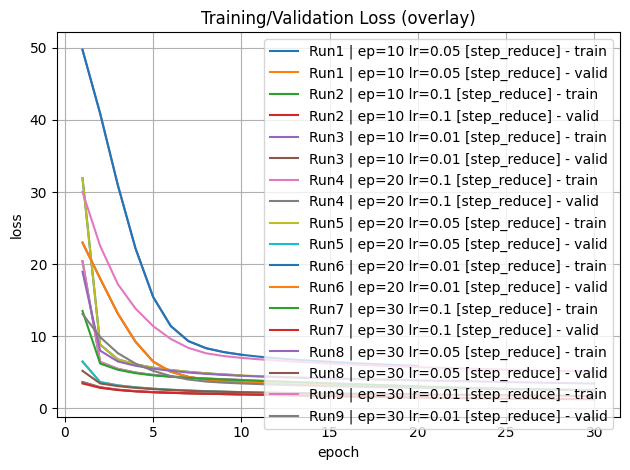

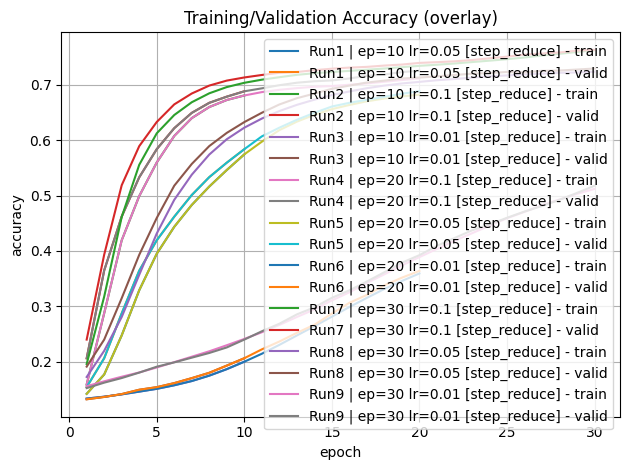

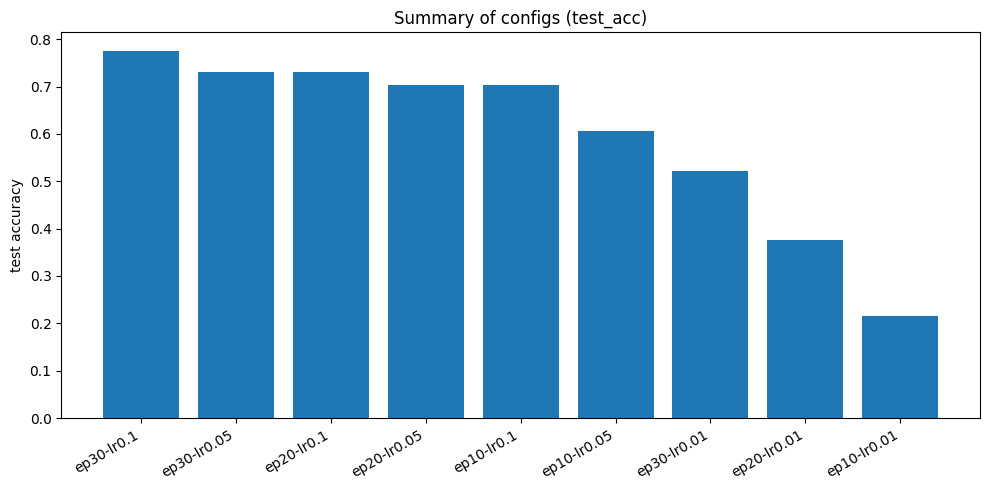

All done in 0.12 d 2.84 h 170.58 m 10234.55 s


In [21]:
if __name__ == "__main__":
        # 3x3 網格：共 9 組
    epoch_list = [10, 20, 30]
    lr_list    = [0.10, 0.05, 0.01]
    configs = [{"epochs": ep, "lr": lr} for ep, lr in product(epoch_list, lr_list)]
    # 你可以自由調整這個數字（每個 config 內用幾個 core）
    per_config_cores = 5
    t0 = time.perf_counter()
    results = run_many_configs_in_parallel(
        configs,
        data_root=".",
        batch_size=128,
        global_batch_size=256,
        per_config_cores=per_config_cores,
        start_method="fork",   
        save_dir="results_parallel"
    )

    t1 = time.perf_counter()
    print(f"All done in {(t1 - t0)/60/60/24:.2f} d {(t1 - t0)/60/60:.2f} h {(t1 - t0)/60:.2f} m {t1 - t0:.2f} s")

